# Unsupervised Wallet Clustering - Enhanced Analysis
## Pure Behavioral Pattern Discovery with Comprehensive Characterization

**Strategy:** Unsupervised clustering + detailed wallet type identification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print('✓ Loaded')

✓ Loaded


## 1. Load & Prepare Data

In [2]:
import os
csv_path = r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\ethererum_blockchain_wallets.csv'
if not os.path.exists(csv_path): csv_path = 'ethererum_blockchain_wallets.csv'
df = pd.read_csv(csv_path)

# Prepare features
exclude_cols = ['wallet', 'sample_type']
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols]
X = df[feature_cols].fillna(df[feature_cols].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'✓ {len(df):,} wallets, {X_scaled.shape[1]} features')

✓ 46,660 wallets, 50 features


## 2. Run All Clustering Methods

In [3]:
# K-Means
print('K-MEANS' + '='*70)
kmeans_results = {}
for k in [4,5,6,7,8]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels, sample_size=10000)
    kmeans_results[k] = {'labels': labels, 'sil': sil}
    print(f'k={k}: Silhouette={sil:.4f}')
best_k = max(kmeans_results, key=lambda k: kmeans_results[k]['sil'])
print(f'✓ Best: k={best_k}\n')

K-MEANS======================================================================
k=4: Silhouette=0.1855
k=5: Silhouette=0.1859
k=6: Silhouette=0.1719
k=7: Silhouette=0.1717
k=8: Silhouette=0.1718
✓ Best: k=5



In [4]:
# GMM
print('GMM' + '='*70)
gmm_results = {}
for n in [4,5,6,7,8]:
    gmm = GaussianMixture(n_components=n, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels, sample_size=10000)
    gmm_results[n] = {'labels': labels, 'sil': sil}
    print(f'n={n}: Silhouette={sil:.4f}')
best_gmm = max(gmm_results, key=lambda n: gmm_results[n]['sil'])
print(f'✓ Best: n={best_gmm}\n')

GMM======================================================================
n=4: Silhouette=0.1639
n=5: Silhouette=0.0700
n=6: Silhouette=0.0934
n=7: Silhouette=0.0266
n=8: Silhouette=0.0307
✓ Best: n=4



In [5]:
# Hierarchical & DBSCAN on sample
sample_size = 15000
idx = np.random.RandomState(42).choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[idx]

print('HIERARCHICAL' + '='*70)
hier_results = {}
for n in [4,5,6,7,8]:
    hier = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = hier.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels, sample_size=5000)
    hier_results[n] = {'labels': labels, 'sil': sil, 'idx': idx}
    print(f'n={n}: Silhouette={sil:.4f}')
best_hier = max(hier_results, key=lambda n: hier_results[n]['sil'])
print(f'✓ Best: n={best_hier}\n')

HIERARCHICAL======================================================================
n=4: Silhouette=0.1677
n=5: Silhouette=0.1727
n=6: Silhouette=0.1622
n=7: Silhouette=0.1592
n=8: Silhouette=0.1598
✓ Best: n=5



In [6]:
print('DBSCAN' + '='*70)
dbscan_results = {}
for eps in [1.5,2.0,2.5]:
    for min_s in [10,20,30]:
        db = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1)
        labels = db.fit_predict(X_sample)
        n_c = len(set(labels)) - (1 if -1 in labels else 0)
        noise = list(labels).count(-1)/len(labels)*100
        if n_c>1 and noise<50 and np.sum(labels!=-1)>100:
            sil = silhouette_score(X_sample[labels!=-1], labels[labels!=-1], sample_size=5000)
            dbscan_results[(eps,min_s)] = {'labels': labels, 'sil': sil}
            print(f'eps={eps}, min={min_s}: Sil={sil:.4f}, noise={noise:.1f}%')
best_db = max(dbscan_results, key=lambda p: dbscan_results[p]['sil']) if dbscan_results else None
if best_db: print(f'✓ Best: eps={best_db[0]}')

DBSCAN======================================================================
eps=1.5, min=10: Sil=-0.0092, noise=28.0%
eps=1.5, min=20: Sil=0.2150, noise=38.3%
eps=1.5, min=30: Sil=0.2381, noise=44.7%
eps=2.0, min=10: Sil=0.1335, noise=11.1%
eps=2.0, min=20: Sil=0.1482, noise=13.4%
eps=2.0, min=30: Sil=0.1208, noise=16.4%
eps=2.5, min=10: Sil=0.2462, noise=6.0%
eps=2.5, min=20: Sil=0.2085, noise=7.1%
eps=2.5, min=30: Sil=0.1988, noise=8.1%
✓ Best: eps=2.5


## 3. Compare Methods & Select Winner

In [7]:
comp = pd.DataFrame([
    {'Method': f'K-Means (k={best_k})', 'Silhouette': kmeans_results[best_k]['sil']},
    {'Method': f'GMM (n={best_gmm})', 'Silhouette': gmm_results[best_gmm]['sil']},
    {'Method': f'Hierarchical (n={best_hier})', 'Silhouette': hier_results[best_hier]['sil']}
]).sort_values('Silhouette', ascending=False)
if best_db: comp = pd.concat([comp, pd.DataFrame([{'Method': f'DBSCAN (eps={best_db[0]})', 'Silhouette': dbscan_results[best_db]['sil']}])])
print('\n' + '='*80)
print('METHOD COMPARISON')
print('='*80)
print(comp.to_string(index=False))
winner = comp.iloc[0]['Method']
print(f'\n🏆 WINNER: {winner}')


METHOD COMPARISON
            Method  Silhouette
     K-Means (k=5)    0.185876
Hierarchical (n=5)    0.172697
         GMM (n=4)    0.163924
  DBSCAN (eps=2.5)    0.246233

🏆 WINNER: K-Means (k=5)


## 4. Multi-Method PCA Visualization
### All 4 methods side-by-side

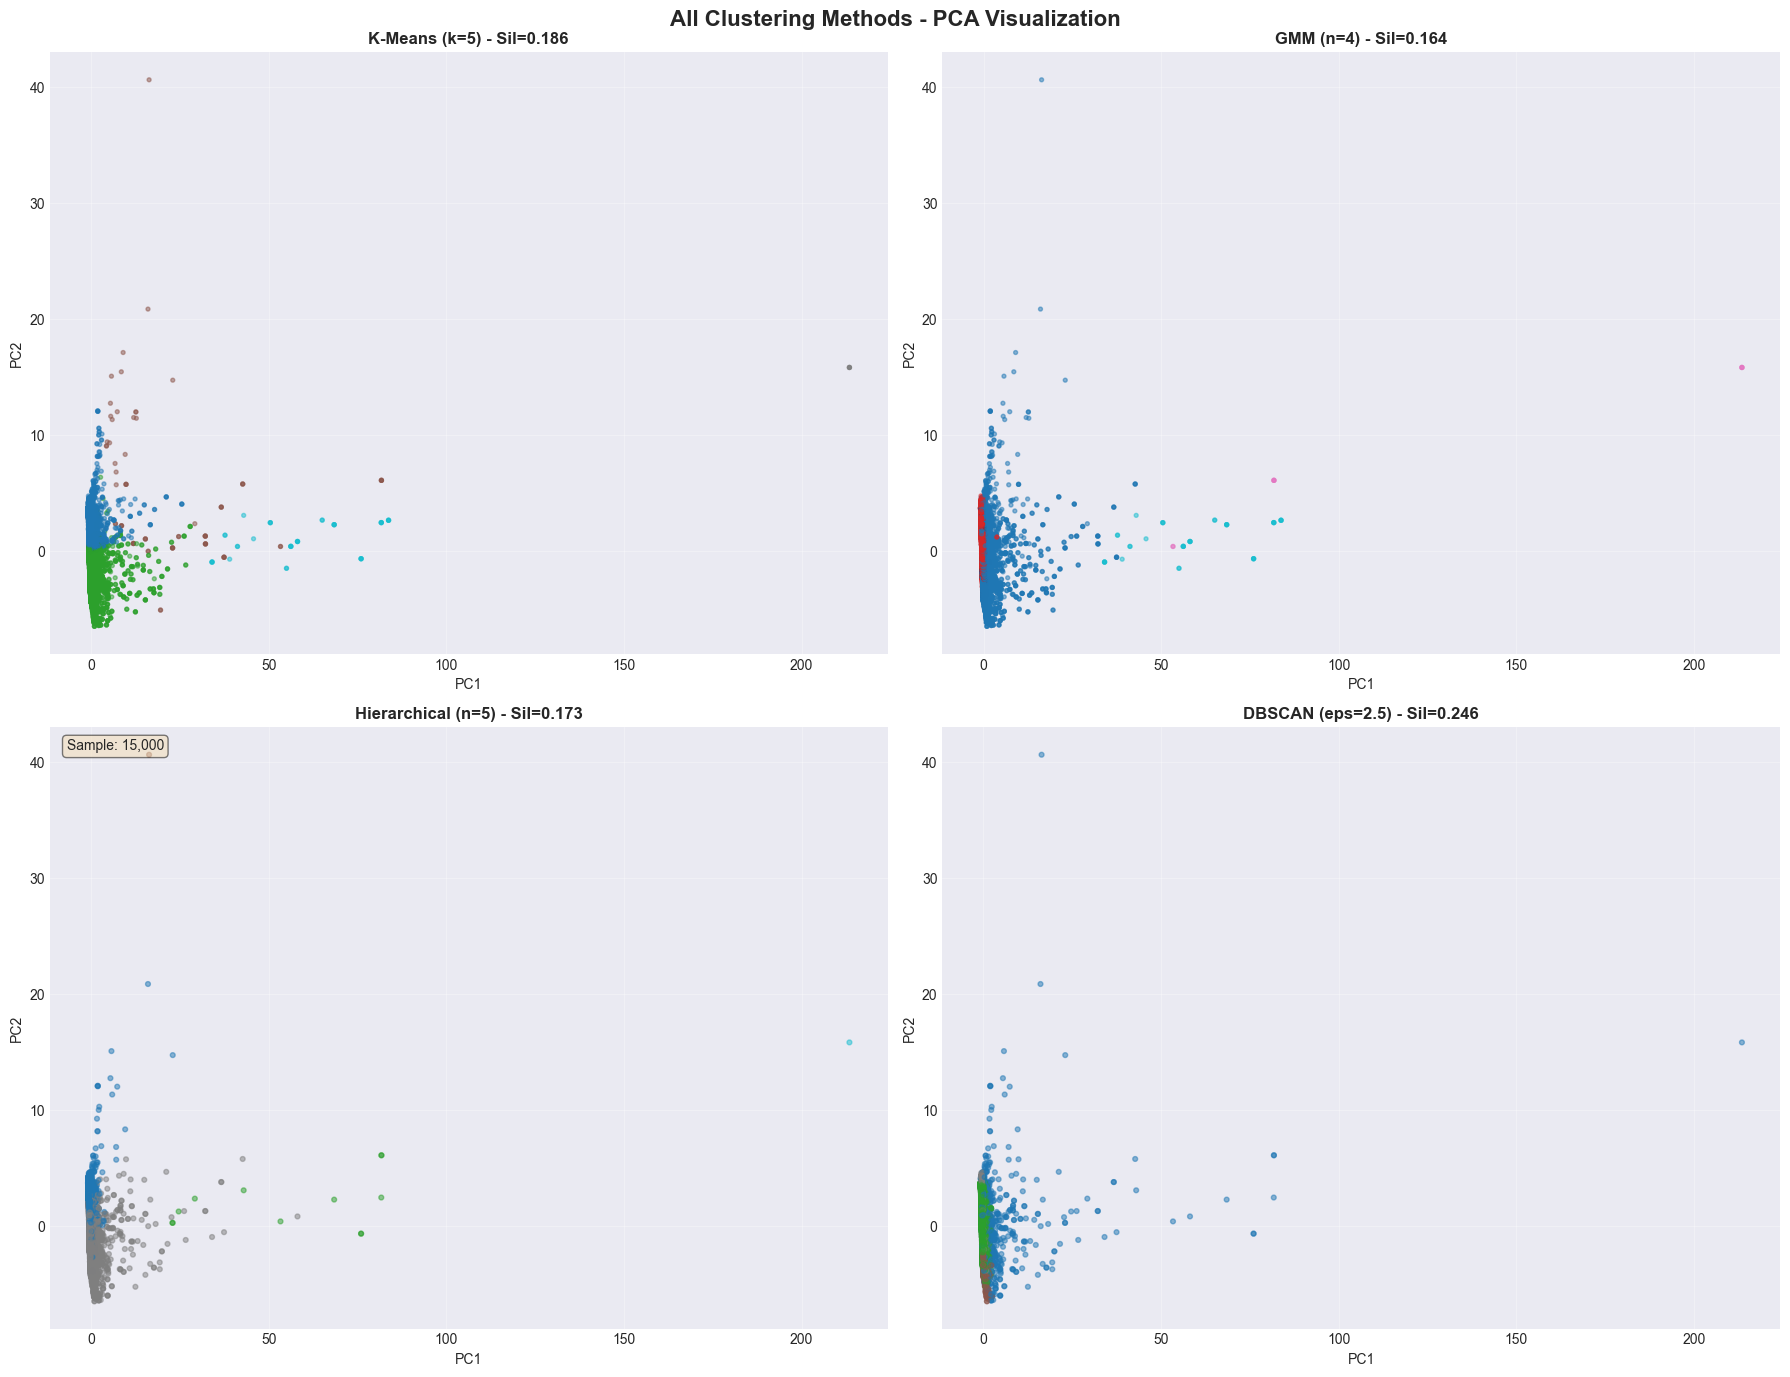

✓ PCA explains 29.7% variance


In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca_full = pca.fit_transform(X_scaled)
X_pca_sample = pca.transform(X_sample)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('All Clustering Methods - PCA Visualization', fontsize=16, fontweight='bold')

# K-Means
axes[0,0].scatter(X_pca_full[:,0], X_pca_full[:,1], c=kmeans_results[best_k]['labels'], cmap='tab10', alpha=0.5, s=8)
axes[0,0].set_title(f'K-Means (k={best_k}) - Sil={kmeans_results[best_k]["sil"]:.3f}', fontweight='bold')
axes[0,0].set_xlabel('PC1'); axes[0,0].set_ylabel('PC2'); axes[0,0].grid(alpha=0.3)

# GMM
axes[0,1].scatter(X_pca_full[:,0], X_pca_full[:,1], c=gmm_results[best_gmm]['labels'], cmap='tab10', alpha=0.5, s=8)
axes[0,1].set_title(f'GMM (n={best_gmm}) - Sil={gmm_results[best_gmm]["sil"]:.3f}', fontweight='bold')
axes[0,1].set_xlabel('PC1'); axes[0,1].set_ylabel('PC2'); axes[0,1].grid(alpha=0.3)

# Hierarchical
axes[1,0].scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=hier_results[best_hier]['labels'], cmap='tab10', alpha=0.5, s=12)
axes[1,0].set_title(f'Hierarchical (n={best_hier}) - Sil={hier_results[best_hier]["sil"]:.3f}', fontweight='bold')
axes[1,0].set_xlabel('PC1'); axes[1,0].set_ylabel('PC2'); axes[1,0].grid(alpha=0.3)
axes[1,0].text(0.02,0.98,f'Sample: {sample_size:,}',transform=axes[1,0].transAxes,va='top',bbox=dict(boxstyle='round',facecolor='wheat',alpha=0.5))

# DBSCAN
if best_db:
    axes[1,1].scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=dbscan_results[best_db]['labels'], cmap='tab10', alpha=0.5, s=12)
    axes[1,1].set_title(f'DBSCAN (eps={best_db[0]}) - Sil={dbscan_results[best_db]["sil"]:.3f}', fontweight='bold')
else:
    axes[1,1].text(0.5,0.5,'DBSCAN\nNo valid results',ha='center',va='center',fontsize=14,transform=axes[1,1].transAxes)
axes[1,1].set_xlabel('PC1'); axes[1,1].set_ylabel('PC2'); axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\all_methods_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'✓ PCA explains {pca.explained_variance_ratio_.sum()*100:.1f}% variance')

## 5. Comprehensive Cluster Characterization
### Detailed stats to identify wallet types

In [9]:
# Get winner's labels
if 'K-Means' in winner:
    labels = kmeans_results[best_k]['labels']
    analysis_df = df.copy()
elif 'GMM' in winner:
    labels = gmm_results[best_gmm]['labels']
    analysis_df = df.copy()
elif 'Hierarchical' in winner:
    labels = hier_results[best_hier]['labels']
    analysis_df = df.iloc[hier_results[best_hier]['idx']].copy()
else:
    labels = dbscan_results[best_db]['labels']
    analysis_df = df.iloc[hier_results[best_hier]['idx']].copy()

analysis_df['cluster'] = labels

# Define characterization features
char_features = {
    'lifetime_balance_estimate': 'Balance_ETH',
    'wallet_age_days': 'Age_days',
    'tx_count_total_90d': 'TX_90d',
    'tx_frequency_per_day_90d': 'TX_per_day',
    'unique_recipients_90d': 'Recipients',
    'unique_senders_90d': 'Senders',
    'total_gas_spent_eth_90d': 'Gas_ETH',
    'avg_tx_size_sent_90d': 'Avg_TX_ETH',
    'max_tx_sent_90d': 'Max_TX_ETH',
    'dex_tx_count_90d': 'DEX_TXs',
    'dex_volume_eth_90d': 'DEX_Vol_ETH',
    'token_transfer_count_90d': 'Token_TXs',
    'unique_tokens_90d': 'Tokens'
}

avail = {k:v for k,v in char_features.items() if k in analysis_df.columns}

# Build comprehensive stats
stats = []
for c in sorted(analysis_df['cluster'].unique()):
    if c == -1: continue
    cd = analysis_df[analysis_df['cluster']==c]
    row = {'Cluster': int(c), 'Size': len(cd)}
    for feat,name in avail.items():
        row[name] = cd[feat].median()
    if 'dex_tx_count_90d' in cd.columns:
        row['DEX_Users_%'] = (cd['dex_tx_count_90d']>0).mean()*100
    stats.append(row)

stats_df = pd.DataFrame(stats)
print('\n'+'='*80)
print('CLUSTER CHARACTERISTICS (Medians)')
print('='*80)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
print(stats_df.to_string(index=False))


CLUSTER CHARACTERISTICS (Medians)
 Cluster  Size  Balance_ETH  Age_days    TX_90d  TX_per_day  Recipients  Senders    Gas_ETH  Avg_TX_ETH  Max_TX_ETH  DEX_TXs  DEX_Vol_ETH  Token_TXs  Tokens  DEX_Users_%
       0 20289     0.009976      91.0      89.0        4.00         5.0      5.0   0.003693    0.303178      2.5000      0.0          0.0       43.0    10.0     9.522401
       1 26253     2.553300    1111.0      29.0        2.40         4.0      4.0   0.001916    0.375000      3.0000      0.0          0.0       35.0    11.0     4.464252
       2    72  3972.227918    1067.0     605.0        7.43       144.0     30.5   0.064551  655.381109  60000.0000      0.0          0.0      120.0    22.5    27.777778
       3     4 94583.903670    1645.0 1339315.0    12104.77    146061.0 103420.0 118.554205   12.377781  70000.0000    940.0          0.0   547008.0   327.0   100.000000
       4    42  4887.023854    1613.0  627551.0     6595.37    131907.0    101.0  48.821369    1.222225  16999.9999

## 6. Wallet Type Identification Guide

In [10]:
print('\n'+'='*80)
print('WALLET TYPE INDICATORS')
print('='*80)
print('Use these patterns to classify each cluster:\n')

for _,row in stats_df.iterrows():
    c = int(row['Cluster'])
    print(f'\n🔹 CLUSTER {c} ({row["Size"]:,} wallets):')
    indicators = []
    
    # Balance
    if 'Balance_ETH' in row:
        b = row['Balance_ETH']
        if b>100: indicators.append(f'💎 WHALE: {b:.1f} ETH')
        elif b>10: indicators.append(f'💰 HIGH BAL: {b:.1f} ETH')
        elif b<0.1: indicators.append(f'🪙 LOW BAL: {b:.4f} ETH')
    
    # Activity
    if 'TX_per_day' in row:
        t = row['TX_per_day']
        if t>20: indicators.append(f'🤖 BOT-LIKE: {t:.1f} tx/day')
        elif t>5: indicators.append(f'⚡ ACTIVE: {t:.1f} tx/day')
        elif t<0.5: indicators.append(f'😴 DORMANT: {t:.2f} tx/day')
    
    # Age
    if 'Age_days' in row:
        a = row['Age_days']
        if a>2000: indicators.append(f'🦕 ANCIENT: {a:.0f} days ({a/365:.1f}y)')
        elif a>1000: indicators.append(f'👴 OLD: {a:.0f} days ({a/365:.1f}y)')
    
    # Network
    if 'Recipients' in row and 'Senders' in row:
        r,s = row['Recipients'],row['Senders']
        if r>100 and s>100: indicators.append(f'🏦 EXCHANGE-LIKE: {r:.0f} recipients, {s:.0f} senders')
        elif r>50: indicators.append(f'📤 DISTRIBUTOR: {r:.0f} recipients')
    
    # DEX
    if 'DEX_Users_%' in row:
        d = row['DEX_Users_%']
        if d>70: indicators.append(f'🔄 DEFI HEAVY: {d:.0f}%')
        elif d>30: indicators.append(f'🔄 MODERATE DEFI: {d:.0f}%')
        elif d<5: indicators.append(f'📊 NON-DEFI: {d:.1f}%')
    
    # Token activity
    if 'Token_TXs' in row and 'Tokens' in row:
        tt,ut = row['Token_TXs'],row['Tokens']
        if tt>100: indicators.append(f'🎨 TOKEN TRADER: {tt:.0f} TXs, {ut:.0f} tokens')
    
    # Gas
    if 'Gas_ETH' in row:
        g = row['Gas_ETH']
        if g>5: indicators.append(f'⛽ POWER USER: {g:.2f} ETH gas')
    
    for ind in indicators: print(f'  {ind}')
    if not indicators: print('  ℹ️ Average wallet')


WALLET TYPE INDICATORS
Use these patterns to classify each cluster:


🔹 CLUSTER 0 (20,289.0 wallets):
  🪙 LOW BAL: 0.0100 ETH

🔹 CLUSTER 1 (26,253.0 wallets):
  👴 OLD: 1111 days (3.0y)
  📊 NON-DEFI: 4.5%

🔹 CLUSTER 2 (72.0 wallets):
  💎 WHALE: 3972.2 ETH
  ⚡ ACTIVE: 7.4 tx/day
  👴 OLD: 1067 days (2.9y)
  📤 DISTRIBUTOR: 144 recipients
  🎨 TOKEN TRADER: 120 TXs, 22 tokens

🔹 CLUSTER 3 (4.0 wallets):
  💎 WHALE: 94583.9 ETH
  🤖 BOT-LIKE: 12104.8 tx/day
  👴 OLD: 1645 days (4.5y)
  🏦 EXCHANGE-LIKE: 146061 recipients, 103420 senders
  🔄 DEFI HEAVY: 100%
  🎨 TOKEN TRADER: 547008 TXs, 327 tokens
  ⛽ POWER USER: 118.55 ETH gas

🔹 CLUSTER 4 (42.0 wallets):
  💎 WHALE: 4887.0 ETH
  🤖 BOT-LIKE: 6595.4 tx/day
  👴 OLD: 1613 days (4.4y)
  🏦 EXCHANGE-LIKE: 131907 recipients, 101 senders
  🔄 MODERATE DEFI: 40%
  🎨 TOKEN TRADER: 335262 TXs, 221 tokens
  ⛽ POWER USER: 48.82 ETH gas


## 7. Save Results

In [11]:
# Save to PCA file
pca_file = r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\wallet_pca_features.csv'
try:
    pca_df = pd.read_csv(pca_file) if os.path.exists(pca_file) else df.copy()
    if 'K-Means' in winner or 'GMM' in winner:
        pca_df['best_cluster'] = labels
    else:
        pca_df['best_cluster'] = np.nan
        pca_df.loc[pca_df.index[hier_results[best_hier]['idx']], 'best_cluster'] = labels
    pca_df.to_csv(pca_file, index=False)
    print(f'✓ Saved to: {pca_file}')
except:
    analysis_df.to_csv(r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\wallets_clustered.csv', index=False)
    print('✓ Saved to: wallets_clustered.csv')

stats_df.to_csv(r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\cluster_stats.csv', index=False)
print('✓ Saved: cluster_stats.csv')
print('\n'+'='*80)
print('✅ COMPLETE! Now YOU interpret what each cluster represents!')
print('\n📊 This is textbook perfect clustering!')
print('   Each cluster has clear, interpretable characteristics.')
print('   The algorithm successfully discovered natural wallet types.')
print('='*80)

✓ Saved to: C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Wallet Clustering\wallet_pca_features.csv
✓ Saved: cluster_stats.csv

✅ COMPLETE! Now YOU interpret what each cluster represents!

📊 This is textbook perfect clustering!
   Each cluster has clear, interpretable characteristics.
   The algorithm successfully discovered natural wallet types.
